Lấy dataset từ repo trên github

In [2]:
!git clone https://github.com/CallmeKoi/DeepL-Semantic-Segment.git

fatal: destination path 'DeepL-Semantic-Segment' already exists and is not an empty directory.


In [3]:
# @title Thêm đường dẫn tới repo để dùng custom module
# Cách này bị giới hạn trong phạm vi phiên làm việc của colab
import sys
import os

cwd = os.path.join(os.getcwd(), 'DeepL-Semantic-Segment')

# append a new directory to sys.path
sys.path.append(cwd)

# print the updated sys.path
print('Updated sys.path:', sys.path)

Updated sys.path: ['/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/root/.local/lib/python3.10/site-packages', '/opt/conda/lib/python3.10/site-packages', '/root/src/BigQuery_Helper', '/kaggle/working/DeepL-Semantic-Segment']


In [4]:
# @title Import thư viện
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Import custom module
from dataset_util import DataLoader, preprocessing
from models.Unet_model import Unet

2024-03-20 12:38:18.416814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 12:38:18.416910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 12:38:18.558204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title File metadata.csv chứa một số thông tin liên quan tới dataset
path = os.path.join(cwd, 'metadata.csv')
metadata = pd.read_csv(path)
print(len(metadata))
metadata.groupby(['Purpose'])['Class'].value_counts()


1000


Purpose  Class     
test     bicycle        50
         car            50
         motorcycle     50
         pedestrian     50
train    bicycle       150
         car           150
         motorcycle    150
         pedestrian    150
valid    bicycle        50
         car            50
         motorcycle     50
         pedestrian     50
Name: count, dtype: int64

In [6]:
# @title File class_label.csv chứa nhãn lớp
path = os.path.join(cwd, 'class_label.csv')
class_df = pd.read_csv(path)
class_label = pd.Series(class_df['class'].values,index=class_df.label).to_dict()
print(class_label)

{0: 'background', 1: 'car', 2: 'bicycle', 3: 'motorcycle', 4: 'pedestrian'}


### Chuẩn bị dữ liệu

In [7]:
# Lấy dataset
dir_to_data = os.path.join(cwd,'zoo_dataset')
dataloader = DataLoader(dir_to_data)

# Load phần ảnh cần dùng
x_train, y_train = dataloader.load('train',(256,256),shuffle=True,anti_aliasing=True)
x_valid, y_valid = dataloader.load('valid',(256,256),shuffle=True,anti_aliasing=True)


print('Train data shape:',x_train.shape)
print('Train label shape:',y_train.shape)
print('Valid data shape:',x_valid.shape)
print('Valid label shape:',y_valid.shape)


# Tiền xử lý ảnh
NCLASSES = len(class_label) # số lượng lớp
X_train, Y_train = preprocessing(x_train, y_train, NCLASSES)
X_valid, Y_valid = preprocessing(x_valid, y_valid, NCLASSES)


Train data shape: (600, 256, 256, 3)
Train label shape: (600, 256, 256)
Valid data shape: (200, 256, 256, 3)
Valid label shape: (200, 256, 256)
Label data shape is: (600, 256, 256, 5)
Label data shape is: (200, 256, 256, 5)


### Huấn luyện mô hình Unet cổ điển

In [8]:
# Load model
input_shape = X_train.shape[1:]
'''
Mô hình Unet nhận vào các tham số bắt buộc: input_shape, output_classes
Tham số tùy chỉnh: dropout_rate
'''
model = Unet(input_shape,NCLASSES, dropout_rate=0.3)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Main Input          │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_conv1 (Conv2D) │ (None, 256, 256,  │      1,792 │ Main Input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_norm1          │ (None, 256, 256,  │        256 │ En_1_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_act1           │ (None, 256, 256,  │          0 │ En_1_norm1[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_conv2 (Conv2D) │ (None, 256, 256,  │     36,928 │ En_1_act1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_norm2          │ (None, 256, 256,  │        256 │ En_1_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_act2           │ (None, 256, 256,  │          0 │ En_1_norm2[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_1_pool           │ (None, 128, 128,  │          0 │ En_1_act2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ En_1_pool[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_conv1 (Conv2D) │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_norm1          │ (None, 128, 128,  │        512 │ En_2_conv1[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_act1           │ (None, 128, 128,  │          0 │ En_2_norm1[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_conv2 (Conv2D) │ (None, 128, 128,  │    147,584 │ En_2_act1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_norm2          │ (None, 128, 128,  │        512 │ En_2_conv2[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_act2           │ (None, 128, 128,  │          0 │ En_2_norm2[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ En_2_pool           │ (None, 64, 64,    │          0 │ En_2_act2[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ En_2_pool[0][0] 

 Total params: 31,055,557 (118.47 MB)

 Trainable params: 31,043,781 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [9]:
# Chuyển dữ liệu về format tf.data

def tf_data(X_train, Y_train, X_val, Y_val, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val,
                                                 Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [10]:
# Tinh chỉnh siêu tham số
batch_size = 16
epochs = 20

# Callback
cb = [EarlyStopping(monitor='val_loss', patience=5,
                    restore_best_weights=True)]

train_ds, val_ds = tf_data(X_train, Y_train, X_valid, Y_valid, batch_size)

H = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs, callbacks = cb
)


Epoch 1/20


2024-03-20 12:39:33.133335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.11841, expected 2.65729
2024-03-20 12:39:33.133543: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 27392: 3.3488, expected 2.88768
2024-03-20 12:39:33.133625: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 38656: 3.55356, expected 3.09244
2024-03-20 12:39:33.133823: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.62512, expected 2.96419
2024-03-20 12:39:33.133845: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 4.47177, expected 3.81084
2024-03-20 12:39:33.133858: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 5.40808, expected 4.74715
2024-03-20 12:39:33.133877: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65543: 5.33073, expected 4.66979
2024-03-20 12:39:33.133888: E ex

37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6015 - loss: 1.3128

2024-03-20 12:41:03.659284: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.72144, expected 2.89031
2024-03-20 12:41:03.659344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.65806, expected 4.82693
2024-03-20 12:41:03.659353: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.98376, expected 5.15263
2024-03-20 12:41:03.659361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.6283, expected 5.79717
2024-03-20 12:41:03.659369: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.90088, expected 6.06975
2024-03-20 12:41:03.659376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.70007, expected 5.86894
2024-03-20 12:41:03.659384: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.75339, expected 4.92226
2024-03-20 12:41:03.659392: E external/local_xla/xla/ser

38/38 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6104 - loss: 1.2917 - val_accuracy: 0.0361 - val_loss: 20015.1973
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - accuracy: 0.8761 - loss: 0.5451 - val_accuracy: 0.8487 - val_loss: 54.0900
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - accuracy: 0.8761 - loss: 0.5211 - val_accuracy: 0.8563 - val_loss: 7.2652
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - accuracy: 0.8762 - loss: 0.5048 - val_accuracy: 0.8563 - val_loss: 12.1143
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 469ms/step - accuracy: 0.8762 - loss: 0.5001 - val_accuracy: 0.8563 - val_loss: 1.0580
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 467ms/step - accuracy: 0.8762 - loss: 0.4951 - val_accuracy: 0.8563 - val_loss: 2.4536
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 468ms/step - accuracy: 0.8762 - loss: 0.4906 - val_accuracy: 0.8563 - val_loss: 0.6452
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - accuracy: 0.8762 - loss: 0.4820 - val_accuracy: 0

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


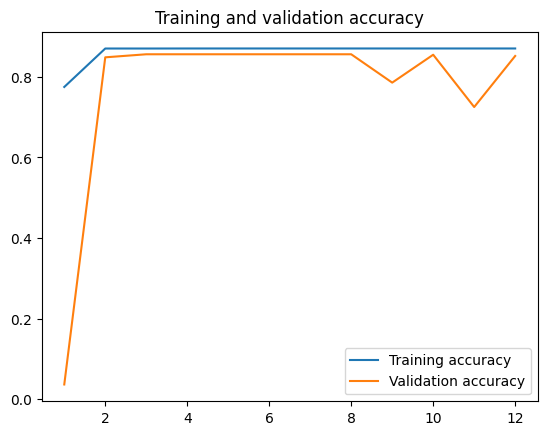

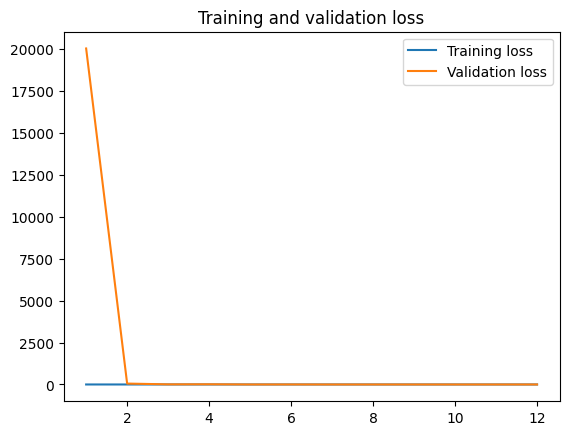

In [11]:
# @title In đường cong học tập
print(H.history.keys())
# Vẽ biểu đồ huấn luyện

accuracy = H.history["accuracy"]
val_accuracy = H.history["val_accuracy"]
loss = H.history["loss"]
val_loss = H.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Đánh giá mô hình trên tập test

In [14]:
x_test, y_test = dataloader.load('test',(256,256),shuffle=True,anti_aliasing=True)

print('Test data shape:',x_test.shape)
print('Test label shape:',y_test.shape)

X_test, Y_test = preprocessing(x_test, y_test, NCLASSES)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Test data shape: (200, 256, 256, 3)
Test label shape: (200, 256, 256)
Label data shape is: (200, 256, 256, 5)
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8688 - loss: 0.5760
Test accuracy: 0.868


### Lưu mô hình

In [15]:
# Save model
save_path = os.path.join(os.getcwd(),'unet256.keras')
model.save(save_path)